In [213]:
from math import sqrt
import regex as re
import os
from glob import glob
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.svm import SVC, SVR
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support, mean_squared_error, accuracy_score

import sklearn_crfsuite
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics

import scipy

import torch
import transformers as ppb
import warnings

from xgboost import XGBClassifier, XGBRFClassifier, XGBRegressor, XGBRFRegressor
from xgboost import plot_importance
from xgboost import plot_importance
from matplotlib import pyplot as plt

warnings.filterwarnings('ignore')

## Interspeech 2020 Challenge
Deadline: May 8th submission of predictions and paper.

Main Webpage: http://www.interspeech2020.org/index.php?m=content&c=index&a=lists&catid=66

Challenge Webpage: http://www.homepages.ed.ac.uk/sluzfil/ADReSS/

# Initial Plan
Only using the transcripts:
- [x] Simple clean and join all sentences, classifiy using DistillBERT, (BERT), (RoBERTa)   ## Done

## Further Feature Engineering:
### Time dimension
- Embed time total time taken - parse time blocks, take first and last
- Embed total time taken per sentence
- Time before starting speech
- Time in between each sentence
- Average / min / max / median time of sentence
- use of special characters
- number of sentences spoken

### Linguistic Features
- Embed special character tokens in speech, pauses etc. (not sure if this needed, tokenzier / and
- classify on a sentence level??
- Also use the Interviewer INV, questions / speech / time...
- Use POS Tags: as OHE vector

## Demographics
- Gender
- Age

## Fine-tuning BERT(-esque) models on spontaneous speech datasets
- fine-tune and re-classify using other spontaneous speech datasets: 

### Further work on
- Analysis of what roBERTa has actually learned in the attention heads

In [2]:
prob_ad_dir = '../train/transcription/cd/*'
controls_dir = '../train/transcription/cc/*'

In [272]:
def extract_data(file_name):
    par = {}
    par['id'] = file_name.split('/')[-1].split('.cha')[0]
    f = iter(open(file_name))
    l = next(f)
    speech = []
    try:
        curr_speech = ''
        while (True):
            if l.startswith('@ID'):
                participant = [i.strip() for i in l.split('|')]
                if participant[2] == 'PAR':
                    par['mmse'] = '' if len(participant[8]) == 0 else float(participant[8])
                    par['sex'] = participant[4][0]
                    par['age'] = int(participant[3].replace(';', ''))
            if l.startswith('*PAR:') or l.startswith('*INV'):
                curr_speech = l
            elif len(curr_speech) != 0 and not(l.startswith('%') or l.startswith('*')):
                curr_speech += l
            elif len(curr_speech) > 0:
                speech.append(curr_speech)
                curr_speech = ''
            l = next(f)
    except StopIteration:
        pass

    clean_par_speech = []
    clean_all_speech = []
    par_speech_time_segments = []
    all_speech_time_segments = []
    is_par = False
    for s in speech:
        def _parse_time(s):
            return [*map(int, re.search('\x15(\d*_\d*)\x15', s).groups()[0].split('_'))]
        
        def _clean(s):
            s = re.sub('\x15\d*_\d*\x15', '', s) # remove time block 
            s = re.sub('\[.*\]', '', s) # remove other speech artifacts [.*]
            s = s.strip()
            s = re.sub('\t|\n|<|>', '', s) # remove tab, new lines, inferred speech??, ampersand, &
            return s
        
        if s.startswith('*PAR:'):
            is_par = True
        elif s.startswith('*INV:'):
            is_par = False
            s = re.sub('\*INV:\t', '', s) # remove prefix
        if is_par:
            s = re.sub('\*PAR:\t', '', s) # remove prefix    
            par_speech_time_segments.append(_parse_time(s))
            clean_par_speech.append(_clean(s))
        all_speech_time_segments.append(_parse_time(s))
        clean_all_speech.append(_clean(s))
        
    par['speech'] = speech
    par['clean_speech'] = clean_all_speech
    par['clean_par_speech'] = clean_par_speech
    par['joined_all_speech'] = ' '.join(clean_all_speech)
    par['joined_all_par_speech'] = ' '.join(clean_par_speech)
    
    # sentence times
    par['per_sent_times'] = [par_speech_time_segments[i][1] - par_speech_time_segments[i][0] for i in range(len(par_speech_time_segments))]
    par['total_time'] =  par_speech_time_segments[-1][1] - par_speech_time_segments[0][0]
    par['time_before_par_speech'] = par_speech_time_segments[0][0]
    par['time_between_sents'] = [0 if i == 0 else max(0, par_speech_time_segments[i][0] - par_speech_time_segments[i-1][1]) 
                                 for i in range(len(par_speech_time_segments))]
    return par

In [273]:
def parse_train_data():
    return _parse_data('../data/train')
    
def parse_test_data():
    return _parse_data('../data/test')

def parse_pre_train_data():
    return _parse_data('/data/train')

def _parse_data(data_dir):
    prob_ad_dir = f'{data_dir}/transcription/cd/*'
    controls_dir = f'{data_dir}/transcription/cc/*'
    
    prob_ad = [extract_data(fn) for fn in glob(prob_ad_dir)]
    controls = [extract_data(fn) for fn in glob(controls_dir)]
    controls_df = pd.DataFrame(controls)
    prob_ad_df = pd.DataFrame(prob_ad)
    controls_df['ad'] = 0
    prob_ad_df['ad'] = 1
    df = pd.concat([controls_df, prob_ad_df]).sample(frac=1).reset_index(drop=True)
    return df

In [274]:
train_df = parse_train_data()

### Base-line TF-IDF -> GBDT / SVM Models

In [7]:
random_state = 42

In [8]:
def cv10_avg(score, model, features, labels):
    return round(cross_val_score(model, features, labels, cv=10, scoring=score).sum() / 10, 2)

In [136]:
def baseline_models(text: pd.Series, labels: list, mmse: list, xgb=True, shuffle=True, print_stats=True):
    ## AD Classification Pred
    # sklearn pipeline
    param_space = {
        'vec__max_features': [100, 500, 1000, 2000, 10000],
        'vec__stop_words': ['english', None],
        'vec__analyzer': ['word', 'char'],
        'vec__sublinear_tf': [True, False]       
    }    
    if xgb:
        param_space['clf__n_estimators'] = [100, 200, 500]  
        param_space['clf__max_depth'] = [3, 5, 10]
    else:
        param_space['clf__C'] = [0.1, 0.5, 1.]              
        param_space['clf__kernel'] = ['rbf', 'sigmoid']    

    clf_pipe = Pipeline([
        ('vec', TfidfVectorizer()),
        ('clf', XGBClassifier(probability=True)) if xgb else ('clf', SVC(probability=True))
    ])
    train_features, test_features, train_labels, test_labels = train_test_split(text, labels, random_state=random_state, test_size=0.2, shuffle=shuffle)
    search = GridSearchCV(clf_pipe, param_space, cv=5, n_jobs=6)
    search.fit(train_features, train_labels)

    clf_pipe.set_params(**search.best_params_)
    print(search.best_params_)
    clf_pipe.fit(train_features, train_labels)
    preds = clf_pipe.predict(test_features)
    if print_stats:
        print('prec, rec, f1 test', precision_recall_fscore_support(test_labels, preds))
        print(f'accu:{cv10_avg("accuracy", clf_pipe, text, labels)}')
        print(f'prec:{cv10_avg("precision", clf_pipe, text, labels)}')
        print(f'rec:{cv10_avg("recall", clf_pipe, text, labels)}')
        print(f'f1:{cv10_avg("f1", clf_pipe, text, labels)}')

    ## MMSE Regression Pred
    reg_features, reg_scores = text.drop([i for i, s in enumerate(mmse) if s == '']).reset_index(drop=True), [s for s in mmse if s != '']
    train_features, test_features, train_scores, test_scores = train_test_split(reg_features, reg_scores, random_state=random_state, test_size=0.2, shuffle=shuffle)

    # sklearn pipeline
    param_space = {
        'vec__max_features': [100, 500, 1000, 2000, 10000],
        'vec__stop_words': ['english', None],
        'vec__analyzer': ['word', 'char'],
        'vec__sublinear_tf': [True, False]
    }    
    if xgb:
        param_space['clf__n_estimators'] = [100, 200, 500]  
        param_space['clf__max_depth'] = [3, 5, 10]  
    else:
        param_space['clf__C'] = [0.1, 0.5, 1.]              
        param_space['clf__kernel'] = ['rbf', 'sigmoid']   

    rgs_pipe = Pipeline([
        ('vec', TfidfVectorizer()),
        ('clf', XGBRegressor()) if xgb else ('clf', SVR())
    ])

    search = GridSearchCV(rgs_pipe, param_space, cv=5, n_jobs=6)
    search.fit(train_features, train_scores)

    rgs_pipe.set_params(**search.best_params_)
    print(search.best_params_)
    rgs_pipe.fit(train_features, train_scores)
    preds = rgs_pipe.predict(test_features)
    if print_stats:
        print('rmse test:', sqrt(mean_squared_error(test_scores, preds)))
        print('rmse cv:', cross_val_score(rgs_pipe, reg_features, reg_scores, cv=10, scoring='neg_root_mean_squared_error').sum() / 10)

    return clf_pipe, rgs_pipe

In [273]:
# SVM - par speech only
clf_svm, rgs_svm = baseline_models(train_df.joined_all_par_speech, train_df.ad,  train_df.mmse, xgb=False)

{'clf__C': 1.0, 'clf__kernel': 'rbf', 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.84615385, 1.        ]), array([1.        , 0.81818182]), array([0.91666667, 0.9       ]), array([11, 11]))
accu:0.86
prec:0.91
rec:0.84
f1:0.85
{'clf__C': 1.0, 'clf__kernel': 'sigmoid', 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': True}
rmse test: 6.715101139865216
rmse cv: -5.828961412118949


In [274]:
# SVM - par + inv speech
clf_svm, rgs_svm = baseline_models(train_df.joined_all_speech, train_df.ad, train_df.mmse, xgb=False)

{'clf__C': 1.0, 'clf__kernel': 'rbf', 'vec__analyzer': 'word', 'vec__max_features': 500, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.83333333, 0.9       ]), array([0.90909091, 0.81818182]), array([0.86956522, 0.85714286]), array([11, 11]))
accu:0.88
prec:0.92
rec:0.87
f1:0.87
{'clf__C': 1.0, 'clf__kernel': 'sigmoid', 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': None, 'vec__sublinear_tf': True}
rmse test: 6.674597551339369
rmse cv: -5.734230349579695


In [412]:
# XGBoost - par speech only
clf_xgb_par, rgs_xgb_par = baseline_models(train_df.joined_all_par_speech, train_df.ad, train_df.mmse, xgb=True)

{'clf__max_depth': 5, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': False}
prec, rec, f1 test (array([0.8, 1. ]), array([1.        , 0.85714286]), array([0.88888889, 0.92307692]), array([ 8, 14]))
accu:0.82
prec:0.84
rec:0.82
f1:0.81
{'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': None, 'vec__sublinear_tf': True}
rmse test: 5.395851815404023
rmse cv: -5.9329590583008045


In [249]:
# XGBoost - par + inv speech
clf_xgb_all, rgs_xgb_all = baseline_models(train_df.joined_all_par_speech, train_df.ad, train_df.mmse, xgb=True)

{'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': False}
prec, rec, f1 test (array([0.75, 0.8 ]), array([0.81818182, 0.72727273]), array([0.7826087 , 0.76190476]), array([11, 11]))
accu:0.79
prec:0.8
rec:0.82
f1:0.79
{'clf__max_depth': 3, 'clf__n_estimators': 200, 'vec__analyzer': 'char', 'vec__max_features': 100, 'vec__stop_words': 'english', 'vec__sublinear_tf': False}
rmse test: 6.370420306954228
rmse cv: -5.603149994529027


## Segment Based Models
- Treating each participant utterance as seperate data points

In [379]:
# explode out each segment into AD / control segments
# Do not shuffle, as parent level segments have already been shuffled
segmented_speech = train_df.apply(lambda r: pd.DataFrame({'t_id': r.id, 'part_id': [str(i) for i, _ in enumerate(r.clean_par_speech)], 'speech_sent': r.clean_par_speech, 'ad': r.ad, 'mmse': r.mmse, 'age': r.age, 'sex': 1 if r.sex == 'm' else 0}), axis=1).tolist()
train_df_segments = pd.concat(segmented_speech).reset_index(drop=True)

In [380]:
# time features
# - Embed time total time taken 
# - parse time blocks, take first and last
# - Embed total time taken per sentence
# - Time before starting speech
# - Time in between each sentence
# - Average / min / max / median time of sentence
time_dims = train_df.loc[:, ['id', 'total_time', 'time_between_sents', 'per_sent_times']]
time_dims['avg_sent_time'] = time_dims.per_sent_times.apply(lambda t: round(sum(t) / len(t)))
time_dims['max_sent_time'] = time_dims.per_sent_times.apply(max)
time_dims['min_sent_time'] = time_dims.per_sent_times.apply(min)
time_dims_eng = time_dims.drop('time_between_sents', axis=1)

def time_seg_df(r):
    return pd.DataFrame({'t_id': r.id,
                         'part_id': [str(i) for i, _ in enumerate(r.per_sent_times)],
                         'total_time': r.total_time, 
                         'segment_time': [t for t in r.per_sent_times],
                         'avg_sent_time': r.avg_sent_time,
                         'max_sent_time': r.max_sent_time,
                         'min_sent_time': r.min_sent_time,
                         })
time_dim_segments = pd.concat(time_dims_eng.apply(time_seg_df, axis=1).tolist())

scaled = StandardScaler().fit_transform(time_dim_segments.loc[:, d_cols])

d_cols = [c for c in time_dim_segments.columns if c not in ['t_id', 'part_id']]
scaled = StandardScaler().fit_transform(time_dim_segments.loc[:, d_cols])
for i, col in enumerate(d_cols):
    time_dim_segments[col] = scaled[:, i]

In [381]:
train_df_segments.age = StandardScaler().fit_transform(pd.DataFrame(train_df_segments.age.to_numpy()).to_numpy())

In [382]:
train_df_segments = train_df_segments.merge(time_dim_segments, on=['t_id', 'part_id'])

In [45]:
# SVM - segmented
clf_svm_segment, rgs_svm_segments = baseline_models(train_df_segments.speech_sent, train_df_segments.ad, train_df_segments.mmse, xgb=False, shuffle=False, print_stats=False) 

{'clf__C': 1.0, 'clf__kernel': 'rbf', 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': True}
prec, rec, f1 test (array([0.93700787, 0.63905325]), array([0.66111111, 0.93103448]), array([0.7752443 , 0.75789474]), array([180, 116]))
accu:0.72
prec:0.73
rec:0.72
f1:0.72


In [15]:
# XGBoost - segmented
clf_xgb_segments, rgs_xgb_segments = baseline_models(train_df_segments.speech_sent, train_df_segments.ad, train_df_segments.mmse, xgb=True, shuffle=False, print_stats=False) 

{'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 1000, 'vec__stop_words': None, 'vec__sublinear_tf': False}
prec, rec, f1 test (array([0.67625899, 0.68152866]), array([0.65277778, 0.70394737]), array([0.66431095, 0.69255663]), array([144, 152]))
accu:0.68
prec:0.67
rec:0.72
f1:0.69
{'clf__max_depth': 3, 'clf__n_estimators': 100, 'vec__analyzer': 'word', 'vec__max_features': 500, 'vec__stop_words': None, 'vec__sublinear_tf': False}
rmse test: 6.489430926085308
rmse cv: -6.842354524498984


In [392]:
def features(df, base_clf_ft_probs, r, i):
    # base clf 
    seq = df[base_clf_ft_probs].tolist()
    seq_item = seq[i]
    features = {
        'bias': 1.,
        'prob_ad': seq_item[1],
        'prob_cc': seq_item[0],
        # time based features
        'total_time': r.total_time,
        'segment_time': r.segment_time,
        'avg_sent_time': r.avg_sent_time,
        'max_sent_time': r.max_sent_time,
        'min_sent_time': r.min_sent_time,
        # demographics
        'age': r.age,
        'sex': r.sex,
        # add in POS tags vectors?
    }
    # context features
    if i > 0:
        features.update({
            '-1:prob_ad': seq[i-1][1],
            '-1:prob_ad': seq[i-1][0],
            '-1:segment_time': df.iloc[i-1].segment_time
        })
    else:
        features['BOS'] = True
    
    if i < len(seq) - 1:
        features.update({
            '+1:prob_ad': seq[i+1][1],
            '+1:prob_cc': seq[i+1][0],
            '+1:segment_time': df.iloc[i+1].segment_time
        })
    else:
        features['EOS'] = True
    return features

In [398]:
def cv_linear_CRF(base_clf_feature_name, segment_model):
    accus, precs, recall, f1s = [], [], [], []
    kf = KFold(n_splits=10, random_state=random_state, shuffle=False)
    accus, precs, recall, f1s = [], [], [], []
    for train_idxs, test_idxs in kf.split(train_df):
        train_x_y =  train_df_segments[train_df_segments.t_id.isin(train_df.iloc[train_idxs].id)]
        test_x_y = train_df_segments[train_df_segments.t_id.isin(train_df.iloc[test_idxs].id)]
        train_x, train_y = train_x_y, train_x_y.ad.tolist()
        test_x, test_y = test_x_y, test_x_y.ad.tolist()

        # refit the base sentence 'embedding layer'. We've already found optimal hyper params - so no need to CV this model
        segment_model.fit(train_x.speech_sent, train_y)
        train_x[base_clf_feature_name] = segment_model.predict_proba(train_x.speech_sent).tolist()
        test_x[base_clf_feature_name] = segment_model.predict_proba(test_x.speech_sent).tolist()

        # Collapse sequences back into DataFrame with CRF features.
        def crf_featurize(X, y):
            collapsed_df = {'t_id': [], 'crf_features': [], 'ad': []}
            for t_id, pt_sq in X.groupby('t_id', sort=False):
                collapsed_df['t_id'].append(t_id)
                collapsed_df['crf_features'].append([features(pt_sq, base_clf_feature_name, r, i) for i, r in enumerate(pt_sq.itertuples())])
                collapsed_df['ad'].append([str(i) for i in pt_sq.ad])
            collapsed_df = pd.DataFrame(collapsed_df)
            return collapsed_df

        seq_data_train = crf_featurize(train_x, train_y)
        seq_data_test = crf_featurize(test_x, test_y)

        params_space = {
            'c1': scipy.stats.expon(scale=0.5).rvs(size=15),
            'c2': scipy.stats.expon(scale=0.05).rvs(size=15),
        }

        crf = sklearn_crfsuite.CRF(
            algorithm='lbfgs',
            all_possible_transitions=True
        )

        gs = GridSearchCV(crf, params_space, cv=5, n_jobs=6)
        gs.fit(seq_data_train.crf_features.tolist(), seq_data_train.ad)

        # one last fit on all train_data
        crf.set_params(**gs.best_params_)
        crf.fit(seq_data_train.crf_features.tolist(), seq_data_train.ad)
        last_test_labels = [p[-1] for p in seq_data_test.ad]
        preds = [p[-1] for p in crf.predict(seq_data_test.crf_features)]
        print(precision_recall_fscore_support(last_test_labels, preds, average='binary', pos_label='1'))
        accus.append(accuracy_score(last_test_labels, preds))
        p, r, f1, _ = precision_recall_fscore_support(last_test_labels, preds, average='binary', pos_label='1')
        precs.append(p)
        recall.append(r)
        f1s.append(f1)
    
    return accus, precs, recall, f1s, crf

In [399]:
accus, precs, recallyry, f1s, svm_crf_model = cv_linear_CRF('clf_svm_preds', clf_svm_segment)

(1.0, 0.8333333333333334, 0.9090909090909091, None)
(0.6666666666666666, 0.5714285714285714, 0.6153846153846153, None)
(0.75, 0.75, 0.75, None)
(0.8333333333333334, 1.0, 0.9090909090909091, None)
(1.0, 1.0, 1.0, None)
(1.0, 0.875, 0.9333333333333333, None)
(1.0, 1.0, 1.0, None)
(0.8, 1.0, 0.888888888888889, None)
(1.0, 1.0, 1.0, None)
(0.6, 0.75, 0.6666666666666665, None)


In [400]:
print('avg accu:', round(sum(accus) / len(accus), 2))
print('avg precs:', round(sum(precs) / len(precs),2))
print('avg recall:', round(sum(recall) / len(recall),2))
print('avg f1s:', round(sum(f1s) / len(f1s),2))

avg accu: 0.87
avg precs: 0.86
avg recall: 0.79
avg f1s: 0.87


In [402]:
svm_crf_model.get_params

<bound method BaseEstimator.get_params of CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.0036552258283559748, c2=0.018382304621495055,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)>

In [403]:
%%time
accus, precs, recall, f1s, xgb_crf_model = cv_linear_CRF('clf_xgb_preds', clf_xgb_segments)
print('avg accu:', round(sum(accus) / len(accus), 2))
print('avg precs:', round(sum(precs) / len(precs),2))
print('avg recall:', round(sum(recall) / len(recall),2))
print('avg f1s:', round(sum(f1s) / len(f1s),2))

(1.0, 0.8333333333333334, 0.9090909090909091, None)
(0.8, 0.5714285714285714, 0.6666666666666666, None)
(0.6666666666666666, 1.0, 0.8, None)
(1.0, 1.0, 1.0, None)
(0.8, 0.8, 0.8000000000000002, None)
(1.0, 0.875, 0.9333333333333333, None)
(1.0, 0.6, 0.7499999999999999, None)
(0.75, 0.75, 0.75, None)
(1.0, 1.0, 1.0, None)
(0.6, 0.75, 0.6666666666666665, None)
avg accu: 0.84
avg precs: 0.86
avg recall: 0.82
avg f1s: 0.83
CPU times: user 45min 10s, sys: 35.1 s, total: 45min 45s
Wall time: 46min 36s


In [405]:
xgb_crf_model.get_params

<bound method BaseEstimator.get_params of CRF(algorithm='lbfgs', all_possible_states=None, all_possible_transitions=True,
    averaging=None, c=None, c1=0.3140761504844387, c2=0.00890634380131646,
    calibration_candidates=None, calibration_eta=None,
    calibration_max_trials=None, calibration_rate=None,
    calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
    gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=None,
    max_linesearch=None, min_freq=None, model_filename=None, num_memories=None,
    pa_type=None, period=None, trainer_cls=None, variance=None, verbose=False)>

In [355]:
print('avg accu:', round(sum(accus) / len(accus), 2))
print('avg precs:', round(sum(precs) / len(precs),2))
print('avg recall:', round(sum(recall) / len(recall),2))
print('avg f1s:', round(sum(f1s) / len(f1s),2))

avg accu: 0.8
avg precs: 0.84
avg recall: 0.74
avg f1s: 0.78


In [351]:
print('avg accu:', round(sum(accus) / len(accus), 2))
print('avg precs:', round(sum(precs) / len(precs),2))
print('avg recall:', round(sum(recall) / len(recall),2))
print('avg f1s:', round(sum(f1s) / len(f1s),2))

avg accu: 0.82
avg precs: 0.84
avg recall: 0.79
avg f1s: 0.81


In [409]:
def feat_impor(pipe):
    feat_impor = [(pipe.steps[0][1].get_feature_names()[i], pipe.steps[1][1].feature_importances_[i]) for i in np.argsort(pipe.steps[1][1].feature_importances_)[::-1][0:20]]
    labs = [i[0] for i in feat_impor]
    scores = [i[1] for i in feat_impor]
    return labs, scores

In [438]:
def plt_feats(clf_labels, clf_impor, rgs_labels, rgs_impor):
    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(8, 5))
    ax1.barh(range(len(clf_impor)), clf_impor, label='AD Classification')
    ax1.set_yticks(range(len(clf_labels)))
    ax1.set_ylabel('TF-IDF Feature')
    ax1.set_yticklabels(clf_labels)
    ax1.yaxis.set_tick_params(labelsize=14)
    ax1.set_xlabel('Feature Importance')

    ax2.barh(range(len(rgs_labels)), rgs_impor, label='MMSE Regression')
    ax2.set_yticks(range(len(rgs_labels)))
    ax2.yaxis.set_tick_params(labelsize=14)
    ax2.set_yticklabels(rgs_labels)
    ax2.set_xlabel('Feature Importance')

    # plt.legend([bar1, bar2], [bar1.get_label(), bar2.get_label()], fontsize=12)
    plt.tight_layout()
    plt.savefig('./feat_impor_xgboost.png')
    plt.show()

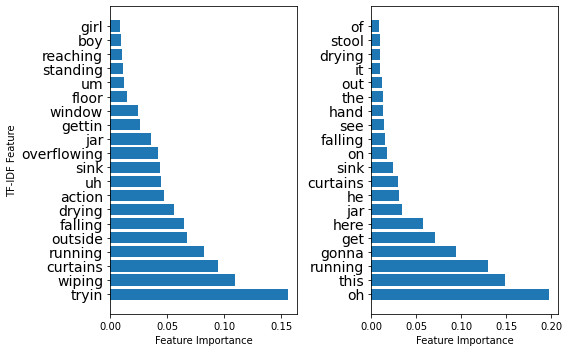

In [439]:
# clf_labels, clf_impor = 
# rgs_labels, rgs_impor =
plt_feats(*feat_impor(clf_xgb_par), * feat_impor(rgs_xgb_par))

## BERT (type) model Experimentaton

In [355]:
# Embedding function
def bert_embed(text: pd.Series, tokenizer, model):
    tokenized = text.apply((lambda x: tokenizer.encode(x, add_special_tokens=True, max_length=512)))

    # pad so can be treated as one batch
    max_len = max([len(i) for i in tokenized.values])
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

    # attention mask - zero out attention scores where there is no input to be processed (i.e. is padding)
    attention_mask = np.where(padded != 0, 1, 0)
    input_ids = torch.tensor(padded)  
    attention_mask = torch.tensor(attention_mask)

    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # check if multiple GPUs are available
    multi_gpu = torch.cuda.device_count() > 1

    if torch.cuda.is_available():
        model = model.to(device)
        input_ids = input_ids.to(device)
        attention_mask = attention_mask.to(device)

    with torch.no_grad():
        last_hidden_states = model(input_ids, attention_mask=attention_mask)
    last_hidden_states = last_hidden_states[0]
    if device.type == 'cuda':
        last_hidden_states = last_hidden_states.cpu()
    features = last_hidden_states[:,0,:].numpy()
    return features, attention_mask

In [327]:
# linear classifier fit/transform
def fit_transform(features, labels: list, mmse: list):
    def cv10_avg_nn(score):
        return cv10_avg(score, lr_clf, features, labels)

    # AD classification task
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, random_state=random_state)
    parameters = {'C': np.linspace(0.0001, 100, 20)}
    grid_search = GridSearchCV(LogisticRegression(), parameters)
    grid_search.fit(train_features, train_labels)
    print('best parameters:', grid_search.best_params_)
    print('best scores: ', grid_search.best_score_)
    lr_clf = LogisticRegression(**grid_search.best_params_)
    lr_clf.fit(train_features, train_labels)
    preds = lr_clf.predict(test_features)
    print('prec, rec, f1 test', precision_recall_fscore_support(test_labels, preds))
    print(f'accu:{cv10_avg_nn("accuracy")} prec:{cv10_avg_nn("precision")}, rec:{cv10_avg_nn("recall")}, f1:{cv10_avg_nn("f1")}')
          
    # MMSE regression task
    # remove missing row
    reg_features, reg_scores = pd.DataFrame(features).drop([i for i, s in enumerate(mmse) if s == '']).to_numpy(), [s for s in mmse if s != '']
    train_features, test_features, train_scores, test_scores = train_test_split(reg_features, reg_scores, random_state=random_state)
    parameters = {'alpha': np.linspace(0.001, 100, 20)}
    grid_search = GridSearchCV(Ridge(), parameters)
    grid_search.fit(train_features, train_scores)
    print('best parameters:', grid_search.best_params_)
    print('best scores: ', grid_search.best_score_)
    reg_model = Ridge(**grid_search.best_params_)
    reg_model.fit(train_features, train_scores)
    preds = reg_model.predict(test_features)
    print('rmse test:', sqrt(mean_squared_error(test_scores, preds)))
    print('rmse cv:', cross_val_score(reg_model, reg_features, reg_scores, cv=10, scoring='neg_root_mean_squared_error').sum() / 10)
    return lr_clf, reg_model

In [315]:
# BERT Large
# model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-large-uncased')

# roBERTa base
# model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')

In [322]:
def load_transformer_model_tokenizer(model_class, tokenizer_class, pretrained_weights):
    tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
    model = model_class.from_pretrained(pretrained_weights)
    return tokenizer, model

In [354]:
def run_model(model_class, tokenizer_class, pretrained_weights, text):
    tokenizer, model = load_transformer_model_tokenizer(model_class, tokenizer_class, pretrained_weights)
    features, _ = bert_embed(text, tokenizer, model)
    clf_model, reg_model = fit_transform(features, train_df.ad, train_df.mmse)
    return tokenizer, model, features, clf_model, reg_model

In [314]:
# Distil BERT - par speech
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_par_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8279411764705882
prec, rec, f1 test (array([0.81818182, 0.8125    ]), array([0.75      , 0.86666667]), array([0.7826087 , 0.83870968]), array([12, 15]))
accu:0.87 prec:0.9, rec:0.87, f1:0.87
best parameters: {'alpha': 5.264105263157894}
best scores:  0.48426174008121115
rmse test: 5.156365006865598
rmse cv: -4.496598650519269


In [317]:
# Distil roBERTa
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'distilroberta-base')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_par_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8294117647058823
prec, rec, f1 test (array([1.        , 0.88235294]), array([0.83333333, 1.        ]), array([0.90909091, 0.9375    ]), array([12, 15]))
accu:0.84 prec:0.86, rec:0.85, f1:0.82
best parameters: {'alpha': 0.001}
best scores:  0.39129614202351315
rmse test: 5.99993232969807
rmse cv: -5.125356983051849


In [318]:
# BERT Base
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_par_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8294117647058823
prec, rec, f1 test (array([1.        , 0.88235294]), array([0.83333333, 1.        ]), array([0.90909091, 0.9375    ]), array([12, 15]))
accu:0.84 prec:0.86, rec:0.85, f1:0.82
best parameters: {'alpha': 0.001}
best scores:  0.39129614202351315
rmse test: 5.99993232969807
rmse cv: -5.125356983051849


In [326]:
# Distil BERT - par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)

best parameters: {'C': 5.263252631578947}
best scores:  0.8147058823529412
prec, rec, f1 test (array([0.90909091, 0.875     ]), array([0.83333333, 0.93333333]), array([0.86956522, 0.90322581]), array([12, 15]))
accu:0.87 prec:0.89, rec:0.89, f1:0.88
best parameters: {'alpha': 5.264105263157894}
best scores:  0.4361080418716384
rmse test: 5.891775312607294
rmse cv: -4.8560381474639875


In [339]:
# Distil roBERT - par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'distilroberta-base')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)

best parameters: {'C': 10.526405263157894}
best scores:  0.8169117647058822
prec, rec, f1 test (array([1.    , 0.9375]), array([0.91666667, 1.        ]), array([0.95652174, 0.96774194]), array([12, 15]))
accu:0.8 prec:0.87, rec:0.79, f1:0.78
best parameters: {'alpha': 0.001}
best scores:  0.43956916829704706
rmse test: 5.961039275583074
rmse cv: -4.485702271630474


In [337]:
# BERT Base -  par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)


best parameters: {'C': 5.263252631578947}
best scores:  0.7661764705882353
prec, rec, f1 test (array([0.90909091, 0.875     ]), array([0.83333333, 0.93333333]), array([0.86956522, 0.90322581]), array([12, 15]))
accu:0.75 prec:0.76, rec:0.78, f1:0.74
best parameters: {'alpha': 5.264105263157894}
best scores:  0.4176459962509897
rmse test: 6.609310719210884
rmse cv: -5.273888313820208


In [338]:
# roBERTa Base - par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-base')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)


best parameters: {'C': 15.789557894736841}
best scores:  0.7411764705882353
prec, rec, f1 test (array([0.76923077, 0.85714286]), array([0.83333333, 0.8       ]), array([0.8       , 0.82758621]), array([12, 15]))
accu:0.72 prec:0.71, rec:0.71, f1:0.69
best parameters: {'alpha': 0.001}
best scores:  0.2898992821805212
rmse test: 5.4664368013907065
rmse cv: -5.453310614652553


In [340]:
# roBERTa Large - par + inv speech
model_class, tokenizer_class, pretrained_weights = (ppb.RobertaModel, ppb.RobertaTokenizer, 'roberta-large')
tokenizer, model, features, clf_model, reg_model = run_model(model_class, tokenizer_class, pretrained_weights, train_df.joined_all_speech)


best parameters: {'C': 5.263252631578947}
best scores:  0.8154411764705882
prec, rec, f1 test (array([0.84615385, 0.92857143]), array([0.91666667, 0.86666667]), array([0.88      , 0.89655172]), array([12, 15]))
accu:0.81 prec:0.88, rec:0.76, f1:0.79
best parameters: {'alpha': 0.001}
best scores:  0.39037099767627437
rmse test: 5.765437868458934
rmse cv: -5.818066430419618


In [358]:
tokenizer, model = load_transformer_model_tokenizer(ppb.DistilBertModel, ppb.DistilBertTokenizer, 'distilbert-base-uncased')
sent_features, mask = bert_embed(train_df_segments.speech_sent, tokenizer, model)

In [370]:
train_df_segments['features'] = [sent for sent in sent_features]
train_df_segments['mask'] = [m for m in mask]

In [372]:
np.save('sent_features_ad_chalng_distil_bert.npy', sent_features)

In [376]:
np.save('sent_mask_ad_chalng_distil_bert.npy', mask)

In [380]:
train_df_segments.shape

(1476, 6)

In [386]:
train_df_segments

,id,speech_sent,ad,mmse,features,mask
0,S072,you mean right now tell you ?,0,29,"[0.063634075, -0.02579525, -0.11341515, -0.195...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1,S072,&uh the boy is stealing cookies out_of the jar .,0,29,"[-0.1428656, 0.107771605, 0.17008701, -0.13180...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
2,S072,and he's on a stool that's falling down .,0,29,"[-0.115731, -0.06755233, 0.051717915, -0.20882...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
3,S072,and the girl is laughing at him .,0,29,"[-0.106318496, -0.04198377, 0.11833834, -0.152...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
4,S072,and the mother is washing dishes but she's pre...,0,29,"[-0.014219768, -0.102059945, 0.15856433, -0.20...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
...,...,...,...,...,...,...
1471,S083,telling him to be quiet .,1,30,"[-0.20028175, -0.17130803, -0.19182582, -0.256...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1472,S083,and &uh let's see .,1,30,"[0.022183776, 0.0958084, 0.25372738, -0.208391...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1473,S083,in the meantime &uh the mother is washing the ...,1,30,"[-0.05771879, -0.07798436, 0.24423543, -0.1021...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."
1474,S083,(..) I don't think I see anything else .,1,30,"[0.08366716, 0.04091748, -0.0035671964, -0.260...","[tensor(1), tensor(1), tensor(1), tensor(1), t..."


In [441]:
[print(l) for l in train_df_segments.speech_sent[100:200]]

and that's all I see on that .
okay, I see a boy in the cookie jar .
I see he has the lid off .
I see that he is standing on a three legged stool and he's about todepart from that three legged stool .
he has one cookie in his hand, handin(g) it down to his sister andshe's reaching up for it .
and I think she's indicating to the boy to keep still so his motherdoesn't hear what's going on .
I see the mother .
&uh I guess she's drying the dishes and she's not paying attentionbecause she's &uh leavin(g) the sink run over and it's spillin(g)all over the floor .
and she must not be conscious because she's standing in it anddoesn't know it .
&um &sh I think she must  I think she's probably lookin(g)out the window as I take the second look .
and I see apparently a couple dirty dishes on the table+top .
I see the cupboards .
&uh I don't know whether they all have knobs on them or not .
doesn't look like the two where the boy and the girl are have knobson the cupboard door .
and I see outside .


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [ ]:
class AD_LSTM(torch.nn.Module):
    
    def __init__(self, input_dim: int, layers=2, hidden_dim=300, dropout=.5, layers=1):
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, layers)
        self.dropout = torch.nn.Dropout(dropout)
        self.fc1 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x, mask):
        # ignore padding
        x = torch.nn.utils.rnn.pack_padded_sequence(x, mask.sum(1).int().view(-1), batch_first=True, enforce_sorted=False)
        x, hidden = self.rnn(x)
        x, _ = torch.nn.utils.pad_packed_sequence(x, batch_first=True)
        rows = torch.arange(0, x.size(0).long())

        x = self.fc1(x)
        x = self.dropout(x)
        return x

In [ ]:
class BertForADClassification(torch.nn.Module):
    def __init__(self, bertModel, time_dims,):
        super().__init__()
        
        self.bertModel = bertModel
        self.dropout = torch.nn.Dropout(0.5)
        
        # separate Linear for OHE of time
        bert_hidden_dim = self.bertModel
    
        self.classifier = nn.Linear()
    
    def forward(input_ids, attention_mask):
        last_hidden_states = self.bertModel(input_ids, attention_mask=attention_mask)
        features = last_hidden_states[:,0,:]

In [ ]:
# Concat all features
features = np.hstack([bert_features, time_features])

In [ ]:
from sklearn.dummy import DummyClassifier
clf = DummyClassifier()

scores = cross_val_score(clf, train_features, train_labels)
print("Dummy classifier score: %0.3f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))